In [105]:
from transformers import AutoModel, AutoTokenizer
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
import torch
import random
from sklearn.manifold import TSNE
from sklearn.metrics import *
from matplotlib import pyplot as plt
import numpy as np
import sqlite3

In [91]:
def diameter(pts):
    # need at least 3 points to construct the convex hull
    if pts.shape[0] <= 1:
        return 0
    if pts.shape[0] == 2:
        return ((pts[0] - pts[1])**2).sum()
    # two points which are fruthest apart will occur as vertices of the convex hull
    hull = spatial.ConvexHull(pts)
    candidates = pts[spatial.ConvexHull(pts).vertices]
    return spatial.distance_matrix(candidates, candidates).max()

def dunn_index(pts, labels, centroids):
    # O(k n log(n)) with k clusters and n points; better performance with more even clusters
    max_intracluster_dist = max(diameter(pts[labels==i]) for i in np.unique(labels))
    # O(k^2) with k clusters; can be reduced to O(k log(k))
    # get pairwise distances between centroids
    cluster_dmat = spatial.distance_matrix(centroids, centroids)
    # fill diagonal with +inf: ignore zero distance to self in "min" computation
    np.fill_diagonal(cluster_dmat, np.inf)
    min_intercluster_dist = cluster_sizes.min()
    return min_intercluster_dist / max_intracluster_dist

In [6]:
con = sqlite3.connect('witt.db')

In [7]:
cur = con.cursor()

In [8]:
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category ORDER BY size DESC')

In [9]:
cur.fetchall()

[('software', 4104),
 ('library', 2101),
 ('framework', 1578),
 ('tool', 1288),
 ('null', 1099),
 ('systems', 812),
 ('programming-language', 687),
 ('platform', 646),
 ('company', 634),
 ('language', 587),
 ('class', 478),
 ('service', 449),
 ('plugin', 430),
 ('component', 420),
 ('application', 395),
 ('api', 395),
 ('program', 374),
 ('extension', 349),
 ('functions', 336),
 ('file-format', 318),
 ('os', 314),
 ('method', 313),
 ('engine', 306),
 ('protocols', 293),
 ('server', 285),
 ('ide', 274),
 ('project', 268),
 ('interface', 263),
 ('format', 249),
 ('feature', 231),
 ('web-framework', 226),
 ('standard', 221),
 ('technique', 220),
 ('algorithm', 208),
 ('module', 204),
 ('website', 203),
 ('environment', 198),
 ('utility', 194),
 ('database', 190),
 ('toolkit', 187),
 ('programming', 184),
 ('product', 183),
 ('editor', 173),
 ('technology', 164),
 ('file', 160),
 ('manager', 158),
 ('way', 156),
 ('cms', 156),
 ('solution', 150),
 ('term', 149),
 ('specification', 148),
 (

In [10]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "programming-language"')
results = cur.fetchall()
results

[('javascript',),
 ('java',),
 ('c#',),
 ('php',),
 ('python',),
 ('c++',),
 ('sql',),
 ('objective-c',),
 ('c',),
 ('r',),
 ('ruby',),
 ('swift',),
 ('vb.net',),
 ('vba',),
 ('python-3.x',),
 ('python-2.7',),
 ('scala',),
 ('excel-vba',),
 ('swing',),
 ('linq',),
 ('perl',),
 ('powershell',),
 ('typescript',),
 ('c++11',),
 ('actionscript-3',),
 ('haskell',),
 ('xslt',),
 ('dom',),
 ('assembly',),
 ('c#-4.0',),
 ('awk',),
 ('groovy',),
 ('sed',),
 ('swift3',),
 ('vbscript',),
 ('clojure',),
 ('linq-to-sql',),
 ('lua',),
 ('ecmascript-6',),
 ('java-8',),
 ('coffeescript',),
 ('vb6',),
 ('access-vba',),
 ('actionscript',),
 ('swift2',),
 ('fortran',),
 ('erlang',),
 ('dart',),
 ('qml',),
 ('applescript',),
 ('scheme',),
 ('lisp',),
 ('elixir',),
 ('glsl',),
 ('jstl',),
 ('ocaml',),
 ('linq-to-xml',),
 ('c++14',),
 ('processing',),
 ('shader',),
 ('common-lisp',),
 ('xslt-1.0',),
 ('vhdl',),
 ('racket',),
 ('wolfram-mathematica',),
 ('verilog',),
 ('julia-lang',),
 ('elisp',),
 ('sparql'

In [11]:
results = np.array(results).squeeze()

In [12]:
results

array(['javascript', 'java', 'c#', 'php', 'python', 'c++', 'sql',
       'objective-c', 'c', 'r', 'ruby', 'swift', 'vb.net', 'vba',
       'python-3.x', 'python-2.7', 'scala', 'excel-vba', 'swing', 'linq',
       'perl', 'powershell', 'typescript', 'c++11', 'actionscript-3',
       'haskell', 'xslt', 'dom', 'assembly', 'c#-4.0', 'awk', 'groovy',
       'sed', 'swift3', 'vbscript', 'clojure', 'linq-to-sql', 'lua',
       'ecmascript-6', 'java-8', 'coffeescript', 'vb6', 'access-vba',
       'actionscript', 'swift2', 'fortran', 'erlang', 'dart', 'qml',
       'applescript', 'scheme', 'lisp', 'elixir', 'glsl', 'jstl', 'ocaml',
       'linq-to-xml', 'c++14', 'processing', 'shader', 'common-lisp',
       'xslt-1.0', 'vhdl', 'racket', 'wolfram-mathematica', 'verilog',
       'julia-lang', 'elisp', 'sparql', 'xquery', 'c#-3.0', 'haml',
       'word-vba', 'facebook-fql', 'xslt-2.0', 'cython', 'aop',
       'matlab-figure', 'python-3.5', 'java-7', 'aspectj', 'python-3.4',
       'el', 'plpgsql',

In [13]:
cur = con.cursor()
cur.execute('SELECT Tag FROM Categories WHERE Category = "website"')
results2 = cur.fetchall()
results2 = np.array(results2).squeeze()
results2

array(['google-maps', 'amazon-web-services', 'google-maps-api-3',
       'amazon-s3', 'gwt', 'google-analytics', 'youtube', 'google-api',
       'google-drive-sdk', 'gmail', 'google-cloud-platform', 'bitbucket',
       'gitlab', 'google-plus', 'google-cloud-storage', 'prism',
       'openstreetmap', 'google-chrome-app', 'html5-audio', 'blogger',
       'tumblr', 'amazon-cloudfront', 'google-apps', 'jsfiddle',
       'google-maps-api-2', 'google-fusion-tables', 'onedrive', 'vimeo',
       'wiki', 'google-form', 'marker', 'google-translate', 'ebay',
       'forum', 'google-webmaster-tools', 'yahoo-finance', 'bing',
       'yahoo-api', 'reddit', 'zope', 'portal', 'freebase', 'amazon-mws',
       'google-search-api', 'google-apps-marketplace',
       'google-geocoding-api', 'universal-analytics', 'tweets', 'twitch',
       'skin', 'gcp', 'mechanicalturk', 'google-analytics-v4', 'skinning',
       'article', 'imgur', 'hotmail', 'chrome-web-store', 'skydrive',
       'aws-code-deploy', 'goog

In [14]:
x = results.tolist()
y = results2.tolist()
x.extend(y)
_results = x

In [15]:
_results = [x.split('-')[0] for x in _results]

In [42]:
_results = list(set(_results))

In [23]:
model = AutoModel.from_pretrained('../models/full/bert-base-uncased/checkpoint-250000/')
tok = AutoTokenizer.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertModel were not initialized from the model checkpoint at ../models/full/bert-base-uncased/checkpoint-250000/ and are newly initial

In [24]:
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0] #First element of model_output contains all token embeddings
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    sum_embeddings = torch.sum(token_embeddings * input_mask_expanded, 1)
    sum_mask = torch.clamp(input_mask_expanded.sum(1), min=1e-9)
    return sum_embeddings / sum_mask

In [43]:
vectors = []
words = []

for x in _results:
    encoded_input = tok(x, return_tensors='pt')
    model_output = model(**encoded_input)

    vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())
    words.append(x)

print(len(vectors), vectors[0].shape)
vectors = np.array(vectors)

680 (1, 768)


In [44]:
vectors = vectors.squeeze()
vectors.shape

(680, 768)

In [45]:
tsne = TSNE()
vectors = tsne.fit_transform(vectors)

/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/opt/conda/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


In [46]:
vectors.shape

(680, 2)

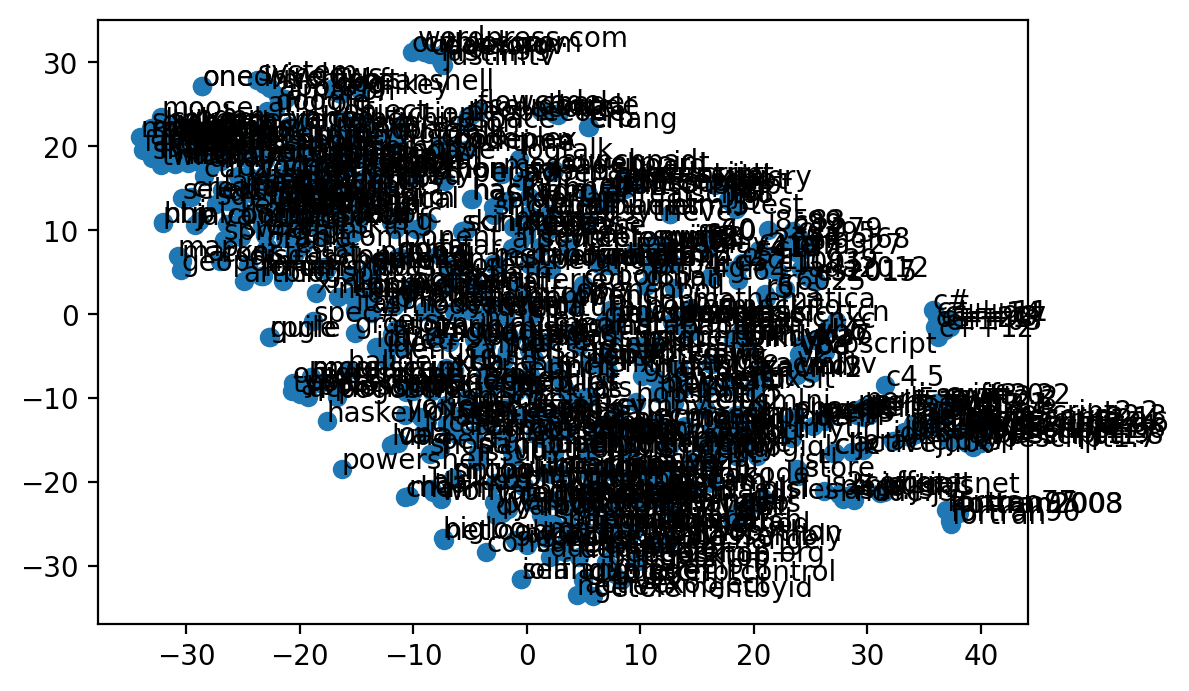

In [47]:
plt.figure(dpi=200)
plt.scatter(vectors.T[0], vectors.T[1])
for i, word in enumerate(words):
    plt.annotate(word, xy=(vectors[i][0], vectors[i][1]))

## Do this with a subset

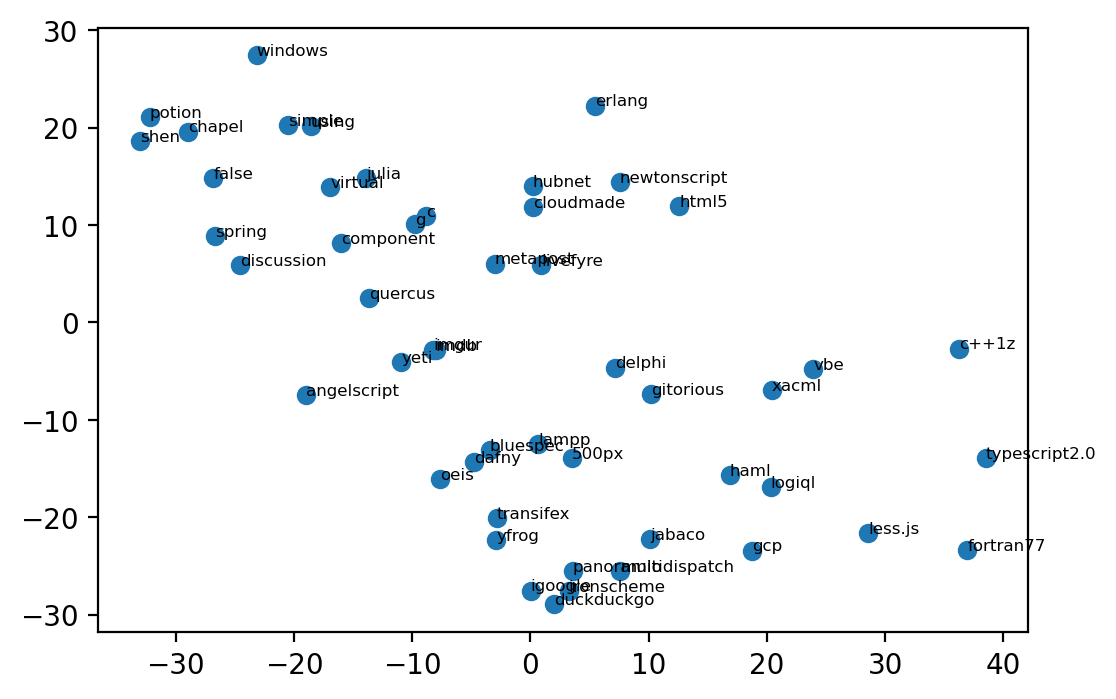

In [48]:
plt.figure(dpi=200)
plt.scatter(vectors[:50].T[0], vectors[:50].T[1])
for i, word in enumerate(words[:50]):
    plt.annotate(word, xy=(vectors[:50][i][0], vectors[:50][i][1]), fontsize=6)

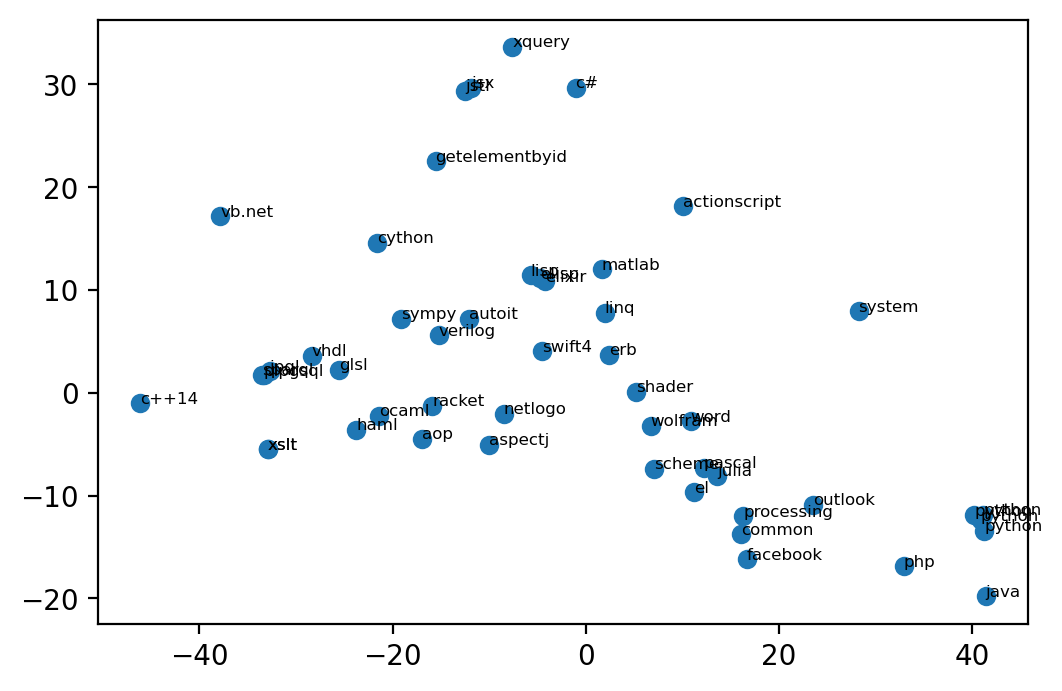

In [41]:
plt.figure(dpi=200)
plt.scatter(vectors[50:100].T[0], vectors[50:100].T[1])
for i, word in enumerate(words[50:100]):
    plt.annotate(word, xy=(vectors[50:100][i][0], vectors[50:100][i][1]), fontsize=6)

In [174]:
print(words[50:100])

['scheme', 'lisp', 'elixir', 'glsl', 'jstl', 'ocaml', 'linq', 'c++14', 'processing', 'shader', 'common', 'xslt', 'vhdl', 'racket', 'wolfram', 'verilog', 'julia', 'elisp', 'sparql', 'xquery', 'c#', 'haml', 'word', 'facebook', 'xslt', 'cython', 'aop', 'matlab', 'python', 'java', 'aspectj', 'python', 'el', 'plpgsql', 'netlogo', 'erb', 'jpql', 'outlook', 'actionscript', 'vb.net', 'sympy', 'python', 'pascal', 'swift4', 'python', 'jsx', 'getelementbyid', 'php', 'autoit', 'system']


In [55]:
cat_to_words = {}

cur = con.cursor()
cur.execute('SELECT Category, COUNT(*) AS size FROM Categories GROUP BY Category')
categories = cur.fetchall()

for cat, size in categories:
    if size == 0:
        continue
        
    cur = con.cursor()
    cur.execute(f'SELECT Tag FROM Categories WHERE Category = "{cat}"')
    results = cur.fetchall()
    
    if len(results) > 10:
        cat_to_words[cat] = np.array(results).squeeze().tolist()

In [56]:
cat_to_words

{'.net': ['mono',
  'umbraco',
  'umbraco7',
  'customvalidator',
  'oxyplot',
  'umbraco6',
  'quickgraph',
  'umbraco5',
  'urhosharp',
  'umbraco4',
  'flourinefx',
  'nosdb'],
 '.net-class': ['x509certificate',
  'transactionscope',
  'sendkeys',
  'dataview',
  'bindingsource',
  'x509certificate2',
  'networkstream',
  'udpclient',
  'activator',
  'dispatchertimer',
  'directoryentry',
  'blockingcollection',
  'sqlparameter',
  'dynamicmethod',
  'typebuilder',
  'httptaskasynchandler',
  'inkmanager'],
 'abbreviation': ['nan',
  'ads',
  'sudo',
  'gsm',
  'geo',
  'fbconnect',
  'lcd',
  'bem',
  'lampp',
  'bde',
  'hdd',
  'nul',
  'ransac',
  'dismax',
  'obex',
  'css-parsing',
  'mbcs',
  'npp',
  'seccomp',
  'vin',
  'nacl-cryptography',
  'u3d',
  'brep',
  'txf',
  'bcg',
  'dvb-t',
  'vigra'],
 'ability': ['multithreading',
  'reflection',
  'overloading',
  'scalability',
  'method-overloading',
  'introspection',
  'function-overloading',
  'connectivity',
  'self

In [68]:
def embed_words(words: list):
    vectors = []

    for x in words:
        encoded_input = tok(x, return_tensors='pt')
        model_output = model(**encoded_input)

        vectors.append(mean_pooling(model_output, encoded_input['attention_mask']).detach().numpy())

    return np.array(vectors).squeeze()

In [69]:
def get_labeled_dataset(vec1: np.ndarray, vec2: np.ndarray):
    return np.concatenate((vec1, vec2)), np.concatenate((np.zeros((len(vec1))), np.ones((len(vec2)))))

In [94]:
def get_dataset_from_multi_vectors(vectors: list):
    X = []
    y = []
    
    c = 0
    for v in vectors:
        X.extend(v)
        y.extend([c] * len(v))
        c += 1
    
    return X, y

In [96]:
bar = tqdm(total=len(cat_to_words))

vectors = []
for cat, words in cat_to_words.items():
    vectors.append(embed_words(words1))
    bar.update(1)
            
X, y = get_dataset_from_multi_vectors(vectors)
calinski_harabasz_score(X, y)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  """Entry point for launching an IPython kernel.


  0%|          | 0/396 [00:00<?, ?it/s]

2.8697073338806305e-09

In [109]:
def intrinsic_eval():
    bar = tqdm(total=100)
    scores = []
    counter = 0
    
    for cat1, words1 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
        for cat2, words2 in random.sample(list(cat_to_words.items()), len(cat_to_words)):
            if cat1 < cat2:
                vec1 = embed_words(words1)
                vec2 = embed_words(words2)

                X, y = get_labeled_dataset(vec1, vec2)
                score = calinski_harabasz_score(X, y)
                scores.append(score)
                counter += 1

                if counter == 100:
                    return scores

                bar.update(1)

In [110]:
intrinsic_eval()

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/100 [00:00<?, ?it/s]

[1.6341334271092405,
 6.900292395677434,
 1.7204410549851847,
 2.9014840207023167,
 2.566508542143454,
 2.954404144441025,
 2.3664142271656563,
 3.255632143759478,
 3.5050923697882066,
 2.8802397533485347,
 2.4235685304843386,
 1.8282829167800059,
 3.5787418169191194,
 3.3733755348390777,
 2.9303731095172845,
 3.8162473822727203,
 1.6417717152878435,
 2.125341383542855,
 1.6013154388041377,
 2.004054746124951,
 2.4210015596195764,
 2.7711127925562993,
 2.445400828232543,
 5.102734337476773,
 2.2118165112263273,
 3.2620913968873775,
 2.1583956330754503,
 2.2767034254298752,
 2.486810064039823,
 2.153836356370016,
 1.8979570085783615,
 2.4646782289534586,
 1.964526855709898,
 1.366157342689084,
 3.3100673720824565,
 2.828476492181201,
 3.280082132466018,
 1.4638013902392086,
 1.8325971324495238,
 2.5309600769354246,
 1.7151692288678893,
 2.0802118991427783,
 1.7338713350127626,
 4.3752757743326045,
 2.445848796864444,
 2.2602718094596583,
 3.184083708343383,
 2.1208168383515518,
 2.13765

In [111]:
np.median(_)

2.4552635129089513